# Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import numpy as np
import time
from datetime import datetime, date, timedelta
from tqdm.auto import tqdm

from scipy.stats import norm
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import yfinance as yf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings('default')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device, torch.__version__)

cuda 2.0.1


In [22]:
%load_ext autoreload
%autoreload 2
from fcnn import ANN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def black_scholes(S, K, T, r, sigma, option='call'):
    """
    Black-Scholes closed-form formula for European call and put options.
    
    Parameters:
        S (float): underlying asset price
        K (float): option strike price
        T (float): time to maturity in years
        r (float): risk-free interest rate
        sigma (float): volatility of the underlying asset
        option (str): 'call' for call option, 'put' for put option (default is 'call')
    
    Returns:
        float: option price according to the Black-Scholes formula
    """
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

# Dataset creation

In [4]:
sp500_calls_options = pd.read_pickle('data/sp500_calls.pkl')
sp500_puts_options = pd.read_pickle('data/sp500_puts.pkl')

In [5]:
df_calls = sp500_calls_options.loc[(sp500_calls_options.opt_price != 0) & sp500_calls_options.opt_price.notna()].copy()
df_calls['S2K'] = df_calls.stock_price / df_calls.strike
df_calls['log_S2K'] = np.log(df_calls.S2K)
df_calls['T'] = df_calls.maturity
df_calls['r'] = np.random.uniform(0.025, 0.075, len(df_calls))
df_calls['log_V2K'] = np.log(df_calls.opt_price / df_calls.strike)
df_calls['sigma'] = df_calls.vol
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94119 entries, 0 to 113
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   contractSymbol  94119 non-null  object        
 1   strike          94119 non-null  float64       
 2   bid             94119 non-null  float64       
 3   ask             94119 non-null  float64       
 4   volume          85896 non-null  float64       
 5   vol             94119 non-null  float64       
 6   expir           94119 non-null  datetime64[ns]
 7   stock_price     94119 non-null  float64       
 8   maturity        94119 non-null  float64       
 9   opt_price       94119 non-null  float64       
 10  S2K             94119 non-null  float64       
 11  log_S2K         94119 non-null  float64       
 12  T               94119 non-null  float64       
 13  r               94119 non-null  float64       
 14  log_V2K         94119 non-null  float64       
 15  sigm

In [6]:
df_puts = sp500_puts_options.loc[(sp500_puts_options.opt_price != 0) & sp500_puts_options.opt_price.notna()].copy()
df_puts['S2K'] = df_puts.stock_price / df_puts.strike
df_puts['log_S2K'] = np.log(df_puts.S2K)
df_puts['T'] = df_puts.maturity
df_puts['r'] = np.random.uniform(0.025, 0.075, len(df_puts))
df_puts['log_V2K'] = np.log(df_puts.opt_price / df_puts.strike)
df_puts['sigma'] = df_puts.vol
df_puts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93405 entries, 0 to 115
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   contractSymbol  93405 non-null  object        
 1   strike          93405 non-null  float64       
 2   bid             93405 non-null  float64       
 3   ask             93405 non-null  float64       
 4   volume          84477 non-null  float64       
 5   vol             93405 non-null  float64       
 6   expir           93405 non-null  datetime64[ns]
 7   stock_price     93405 non-null  float64       
 8   maturity        93405 non-null  float64       
 9   opt_price       93405 non-null  float64       
 10  S2K             93405 non-null  float64       
 11  log_S2K         93405 non-null  float64       
 12  T               93405 non-null  float64       
 13  r               93405 non-null  float64       
 14  log_V2K         93405 non-null  float64       
 15  sigm

In [7]:
train_df_calls, test_df_calls = train_test_split(df_calls, test_size=0.2, random_state=42)
train_df_puts, test_df_puts = train_test_split(df_puts, test_size=0.2, random_state=42)

In [8]:
class MyDataset(Dataset):
    def __init__(self, df, columns, target):
        self.df = df
        self.columns = columns
        self.target = target
        self.data_tensor = torch.Tensor(df[columns].values)
        self.target_tensor = torch.Tensor(df[target].values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (self.data_tensor[idx], self.target_tensor[idx])

### Two types

In [4]:
columns_a = [
    'log_S2K',
    'T',
    'r',
    'log_V2K'
]
columns_b = [
    'log_S2K',
    'T',
    'r'
]
target = 'sigma'

In [10]:
train_ds_calls_a = MyDataset(train_df_calls, columns_a, target)
test_ds_calls_a = MyDataset(test_df_calls, columns_a, target)
train_ds_puts_a = MyDataset(train_df_puts, columns_a, target)
test_ds_puts_a = MyDataset(test_df_puts, columns_a, target)

train_ds_calls_b = MyDataset(train_df_calls, columns_b, target)
test_ds_calls_b = MyDataset(test_df_calls, columns_b, target)
train_ds_puts_b = MyDataset(train_df_puts, columns_b, target)
test_ds_puts_b = MyDataset(test_df_puts, columns_b, target)

In [11]:
train_dl_calls_a = DataLoader(train_ds_calls_a, batch_size=5_000, shuffle=True)
test_dl_calls_a = DataLoader(test_ds_calls_a, batch_size=5_000, shuffle=False)
train_dl_puts_a = DataLoader(train_ds_puts_a, batch_size=5_000, shuffle=True)
test_dl_puts_a = DataLoader(test_ds_puts_a, batch_size=5_000, shuffle=False)

train_dl_calls_b = DataLoader(train_ds_calls_b, batch_size=5_000, shuffle=True)
test_dl_calls_b = DataLoader(test_ds_calls_b, batch_size=5_000, shuffle=False)
train_dl_puts_b = DataLoader(train_ds_puts_b, batch_size=5_000, shuffle=True)
test_dl_puts_b = DataLoader(test_ds_puts_b, batch_size=5_000, shuffle=False)

# Network A
## Call options

In [12]:
struct_nn_a = [len(columns_a), 256, 512, 256, 64, 1]
model_a = ANN(struct_nn_a, bn=True, device=device).to(device)
optimizer = torch.optim.Adam(model_a.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [13]:
EXP_NAME = 'NN_A_call'
model_a.train_network(
    optimizer, 
    criterion, 
    train_dl_calls_a, test_dl_calls_a, 
    num_epochs=100, 
    writer=SummaryWriter(f'logs/{EXP_NAME}')
);

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
torch.save(model_a.state_dict(), f'model_checkpoints/best_nn_a_call.pth')

## Put options

In [17]:
struct_nn_a = [len(columns_a), 256, 512, 256, 64, 1]
model_a = ANN(struct_nn_a, bn=True, device=device).to(device)
optimizer = torch.optim.Adam(model_a.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [18]:
EXP_NAME = 'NN_A_put'
model_a.train_network(
    optimizer, 
    criterion, 
    train_dl_puts_a, test_dl_puts_a, 
    num_epochs=100, 
    writer=SummaryWriter(f'logs/{EXP_NAME}')
);

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
torch.save(model_a.state_dict(), f'model_checkpoints/best_nn_a_put.pth')

# Network B
## Call options

In [30]:
struct_nn_b = [len(columns_b), 256, 512, 256, 64, 1]
model_b = ANN(struct_nn_b, bn=True, device=device).to(device)
optimizer = torch.optim.Adam(model_b.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [31]:
EXP_NAME = 'NN_B_call'
model_b.train_network(
    optimizer, 
    criterion, 
    train_dl_calls_b, test_dl_calls_b, 
    num_epochs=100, 
    writer=SummaryWriter(f'logs/{EXP_NAME}')
);

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
torch.save(model_b.state_dict(), f'model_checkpoints/best_nn_b_call.pth')

## Put options

In [24]:
struct_nn_b = [len(columns_b), 256, 512, 256, 64, 1]
model_b = ANN(struct_nn_b, bn=True, device=device).to(device)
optimizer = torch.optim.Adam(model_b.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [25]:
EXP_NAME = 'NN_B_put'
model_b.train_network(
    optimizer, 
    criterion, 
    train_dl_puts_b, test_dl_puts_b, 
    num_epochs=100, 
    writer=SummaryWriter(f'logs/{EXP_NAME}')
);

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
torch.save(model_b.state_dict(), f'model_checkpoints/best_nn_b_put.pth')

# Test on MSFT data

In [23]:
struct_nn_a = [len(columns_a), 256, 512, 256, 64, 1]
struct_nn_b = [len(columns_b), 256, 512, 256, 64, 1]

model_a_call = ANN(struct_nn_a, bn=True, device=device).to(device)
model_a_call.load_state_dict(torch.load('model_checkpoints/best_nn_a_call.pth'))

model_a_put = ANN(struct_nn_a, bn=True, device=device).to(device)
model_a_put.load_state_dict(torch.load('model_checkpoints/best_nn_a_put.pth'))

model_b_call = ANN(struct_nn_b, bn=True, device=device).to(device)
model_b_call.load_state_dict(torch.load('model_checkpoints/best_nn_b_call.pth'))

model_b_put = ANN(struct_nn_b, bn=True, device=device).to(device)
model_b_put.load_state_dict(torch.load('model_checkpoints/best_nn_b_put.pth'))

<All keys matched successfully>

In [6]:
data_description = '''
    msft_calls - list of pandas DataFrames, every item corresponds expiration 
                 expiration date from `expirations`. Each DF contains trading
                 info about call option
    
    msft_puts - same but for put options
    
    expirations - tuple of expirations dates in string format `YYYY-MM-DD`
'''

msft_calls = pd.read_pickle('data/msft_calls.pickle')
msft_puts = pd.read_pickle('data/msft_puts.pickle')
expirations = pd.read_pickle('data/expirations.pickle')

msft_stock_price = 294.3900146484375
evaluation_date = '2022-03-16'

maturities = np.array([
    (datetime.strptime(expiration, '%Y-%m-%d') - 
    (datetime.strptime(evaluation_date, '%Y-%m-%d') if evaluation_date else datetime.today())).days / 256 
    for expiration in expirations
])

## Surfaces

In [7]:
df_lens = np.array([len(df) for df in msft_calls])
indxs = np.where((df_lens >= 40) & (df_lens <= 90))[0]

msft_calls = [msft_calls[i] for i in indxs]
expirations_calls = [expirations[i] for i in indxs]
maturities_calls = maturities[indxs]

strikes_call = msft_calls[0].strike
for row in msft_calls:
  strikes_call = np.intersect1d(strikes_call, row.strike)

opt_prices_call = np.array([(df.bid + df.ask)[df.strike.isin(strikes_call)] / 2 for df in msft_calls])
opt_prices_call[np.isnan(opt_prices_call)] = 3.5e-2

vols_call = np.array([df.impliedVolatility.loc[df.strike.isin(strikes_call)] for df in msft_calls])

In [8]:
df_lens = np.array([len(df) for df in msft_puts])
indxs = np.where((df_lens >= 40) & (df_lens <= 90))[0]

msft_puts = [msft_puts[i] for i in indxs]
expirations_puts = [expirations[i] for i in indxs]
maturities_puts = maturities[indxs]

strikes_put = msft_puts[0].strike
for row in msft_puts:
  strikes_put = np.intersect1d(strikes_put, row.strike)

opt_prices_put = np.array([(df.bid + df.ask)[df.strike.isin(strikes_put)] / 2 for df in msft_puts])
opt_prices_put[np.isnan(opt_prices_put)] = 3.5e-2

vols_put = np.array([df.impliedVolatility.loc[df.strike.isin(strikes_put)] for df in msft_puts])

In [9]:
nn_a_call_surface = model_a_call.iv_surface(strikes_call, maturities_calls, msft_stock_price, opt_prices_call)
nn_a_put_surface = model_a_put.iv_surface(strikes_put, maturities_puts, msft_stock_price, opt_prices_put)

nn_b_call_surface = model_b_call.iv_surface(strikes_call, maturities_calls, msft_stock_price, opt_prices_call)
nn_b_put_surface = model_b_put.iv_surface(strikes_put, maturities_puts, msft_stock_price, opt_prices_put)

In [10]:
print(MSE(vols_call, nn_a_call_surface))
print(MSE(vols_put, nn_a_put_surface))

print(MSE(vols_call, nn_b_call_surface))
print(MSE(vols_put, nn_b_put_surface))

0.0008473729130117469
0.0005402679568725945
0.0030122758225238264
0.00213699396939992


In [11]:
def plot_surface(X,Y,Z, title):
    X, Y = np.meshgrid(X, Y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,6))
    ax.set_title(title)

    surf = ax.plot_surface(X, Y, Z, 
                        cmap=cm.coolwarm,
                        linewidth=0.1,
                        edgecolor='white')

    fig.colorbar(surf, shrink=0.3, aspect=10)
    ax.set_zlabel('Implied volatility')
    ax.set_xlabel('Strike, $')
    ax.set_ylabel('Maturity, years')
    plt.show()

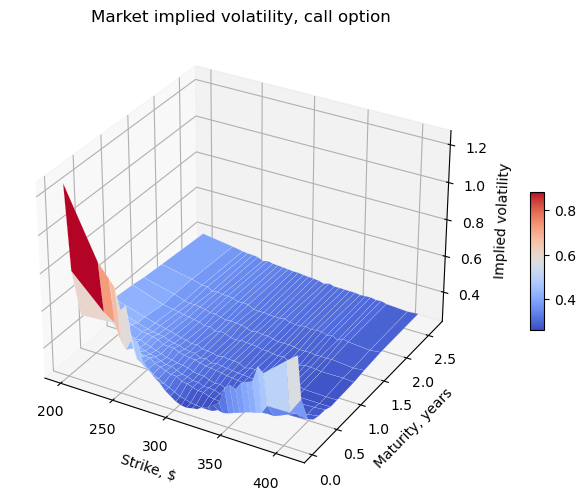

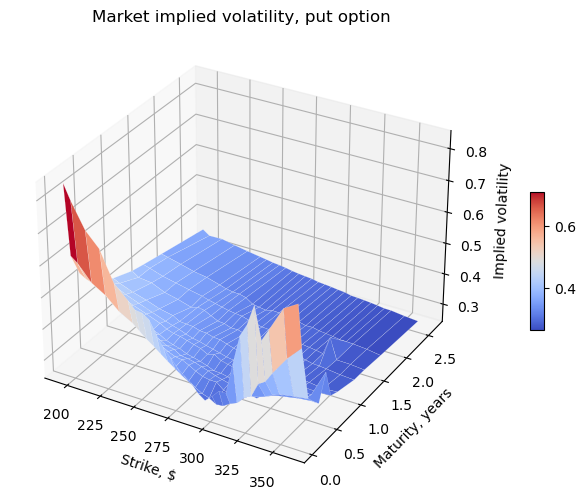

In [12]:
plot_surface(strikes_call, maturities_calls, vols_call, title='Market implied volatility, call option');
plot_surface(strikes_put, maturities_puts, vols_put, title='Market implied volatility, put option');

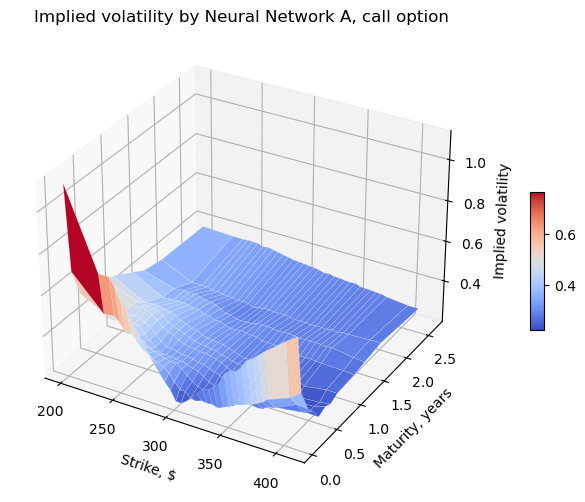

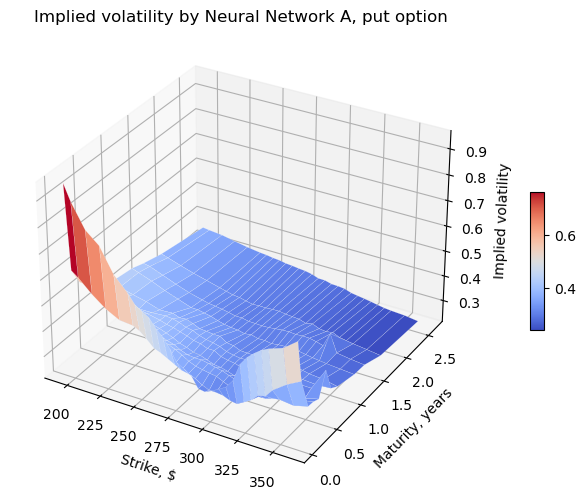

In [13]:
plot_surface(strikes_call, maturities_calls, nn_a_call_surface, title='Implied volatility by Neural Network A, call option')
plot_surface(strikes_put, maturities_puts, nn_a_put_surface, title='Implied volatility by Neural Network A, put option')

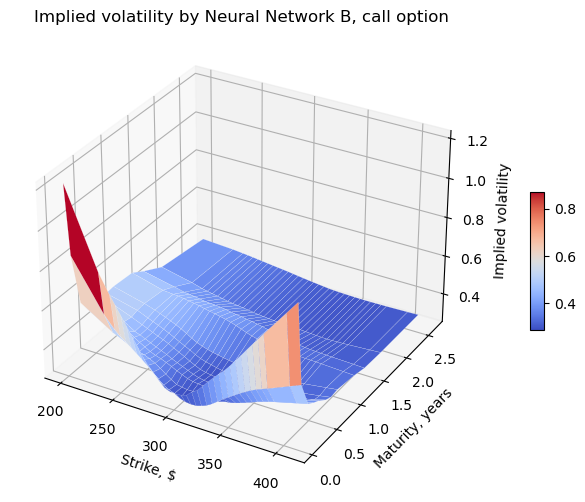

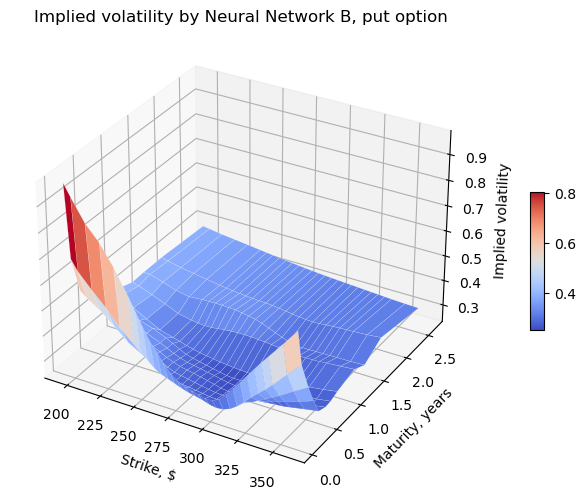

In [14]:
plot_surface(strikes_call, maturities_calls, nn_b_call_surface, title='Implied volatility by Neural Network B, call option')
plot_surface(strikes_put, maturities_puts, nn_b_put_surface, title='Implied volatility by Neural Network B, put option')

In [17]:
import pickle

with open('data/results/nn_a_call_surface.pkl', 'wb') as f:
    pickle.dump(nn_a_call_surface, f)

with open('data/results/nn_a_put_surface.pkl', 'wb') as f:
    pickle.dump(nn_a_put_surface, f)

with open('data/results/nn_b_call_surface.pkl', 'wb') as f:
    pickle.dump(nn_b_call_surface, f)

with open('data/results/nn_b_put_surface.pkl', 'wb') as f:
    pickle.dump(nn_b_put_surface, f)

## MSE on all data

In [24]:
print(model_a_call.MSE_all(msft_calls, maturities_calls, msft_stock_price, 0.05))
print(model_a_put.MSE_all(msft_puts, maturities_puts, msft_stock_price, 0.05))
print(model_b_call.MSE_all(msft_calls, maturities_calls, msft_stock_price, 0.05))
print(model_b_put.MSE_all(msft_puts, maturities_puts, msft_stock_price, 0.05))

0.0068367544251631985
0.0017097129851909919
0.028798029462772642
0.015322383412234014


c:\Users\akhar\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
